In [30]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import matplotlib.pyplot as plt
import scipy as sp
import datetime

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import ar_select_order

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, _TS
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import OneHotEncoder
from utilsforecast.plotting import plot_series

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

import warnings
warnings.filterwarnings('ignore')# Чтобы не раздражали

pd.set_option('display.max_columns', None) # Чтобы показывались все колонки
%matplotlib inline

VALIDATION_HORIZON = 62

In [8]:
import seaborn as sns

In [9]:
def plotly_df(df, title=''):
    data = []

    for column in df.columns:
        if column == 'ds':
            df = df.set_index('ds')
        if column != 'ds':
            trace = go.Scatter(
                x = df.index,
                y = df[column],
                mode = 'lines',
                name = column
            )
            data.append(trace)

    layout = dict(title = title, template='plotly_white')
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [10]:
def plot_acf_pacf(data, col='y'):
    if isinstance(data, pd.DataFrame):
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))
        plot_acf(data[col], ax=axs[0])
        plot_pacf(data[col], ax=axs[1])
    else:
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))
        plot_acf(data, ax=axs[0])
        plot_pacf(data, ax=axs[1])
    plt.show()

In [11]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    print ('\nNull Hypothesis: The series has a unit root. Data is NON stationary.')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    print ('\nNull Hypothesis: The process is trend stationary.')    
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

# EDA

In [12]:
ts = pd.read_csv('/kaggle/input/time-series-1/HW_1_2_ts.csv')
calendar = pd.read_csv('/kaggle/input/time-series-1/HW_1_2_calendar.csv')

In [13]:
plotly_df(ts)

In [14]:
# Проверка того, для каждой ли даты есть информация по праздникам

day_with_holiday_info = calendar.date.unique()
if all(list(ts.ds.isin(day_with_holiday_info).values)):
    print("All days have info in calendar")
else:
    print("Non all days have info in calendar")

All days have info in calendar


In [15]:
# Заполнение пропусков в праздниках

calendar.holiday_1 = calendar.holiday_1.fillna('not')
calendar.holiday_2 = calendar.holiday_2.fillna('not')

<Axes: xlabel='exog_param', ylabel='count'>

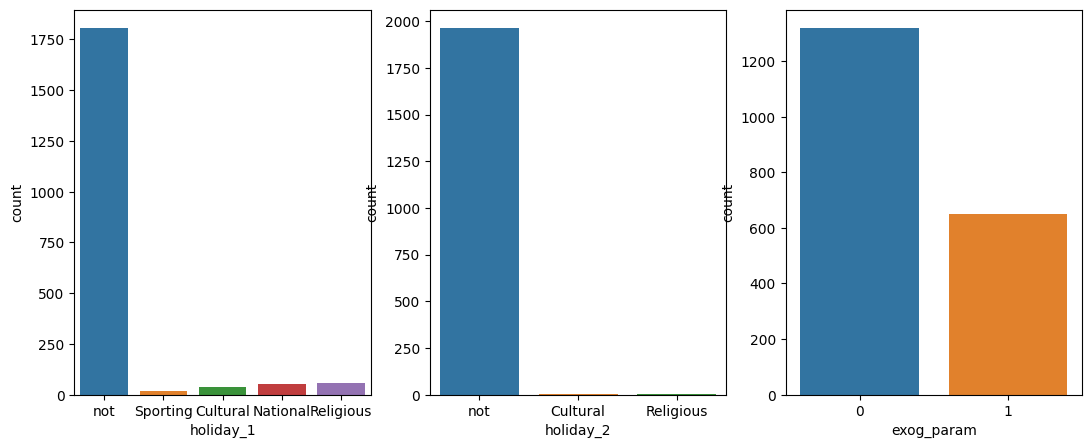

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(13, 5))

sns.countplot(data=calendar,x='holiday_1', ax=axs[0])
sns.countplot(data=calendar,x='holiday_2', ax=axs[1])
sns.countplot(data=calendar,x='exog_param', ax=axs[2])

In [17]:
# Конвертируем даты в datetime
ts.ds = pd.to_datetime(ts.ds)
calendar.date = pd.to_datetime(calendar.date)

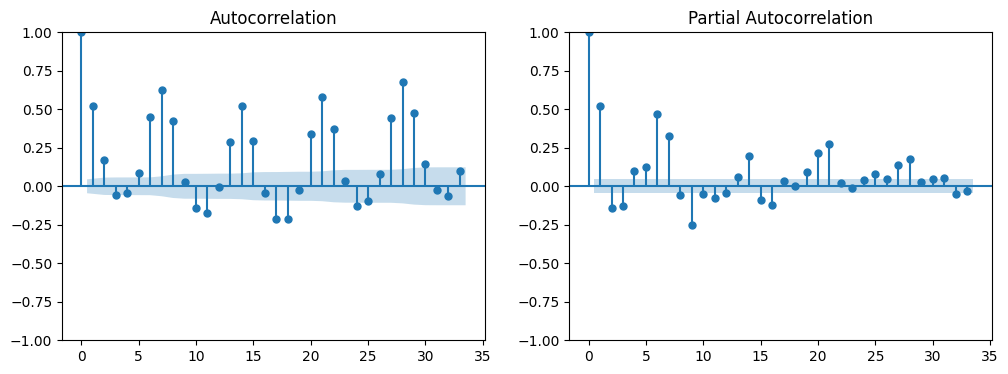

In [18]:
plot_acf_pacf(ts)

Видна ярко выраженная недельная сезонность, поэтому в качестве отправной точки попробуем модель SARIMA. Исходя из графиков функций автокорреляции и частичной автокорреляции, параметры p и q сверху ограничим 2. Параметры P, Q ограничим сверху значением 5. Подбор модели будем производить с помощью AutoARIMA.

In [19]:
ts.y.diff().iloc[1:]

1        177.000
2      -1906.000
3        346.000
4       -868.000
5       2465.000
          ...   
1874    -282.000
1875     542.000
1876     368.000
1877    1093.000
1878   -2009.000
Name: y, Length: 1878, dtype: float64

In [20]:
# Проверим стационарность ряда

adf_test(ts.y)
kpss_test(ts.y)

Results of Dickey-Fuller Test:

Null Hypothesis: The series has a unit root. Data is NON stationary.
Test Statistic                  -3.557
p-value                          0.007
#Lags Used                      25.000
Number of Observations Used   1853.000
Critical Value (1%)             -3.434
Critical Value (5%)             -2.863
Critical Value (10%)            -2.568
dtype: float64
Results of KPSS Test:

Null Hypothesis: The process is trend stationary.
Test Statistic           1.579
p-value                  0.010
Lags Used               12.000
Critical Value (10%)     0.347
Critical Value (5%)      0.463
Critical Value (2.5%)    0.574
Critical Value (1%)      0.739
dtype: float64


Тест KPSS показывает наличие тренда у ряда (что подтверждает визуальное наблюдение). Продифференцируем ряд ещё раз и повторим тест.

In [21]:
ts_diff = ts.copy()
ts_diff.y = ts.y.diff()
ts_diff = ts_diff.iloc[1:]
kpss_test(ts_diff.y)

Results of KPSS Test:

Null Hypothesis: The process is trend stationary.
Test Statistic           0.024
p-value                  0.100
Lags Used               54.000
Critical Value (10%)     0.347
Critical Value (5%)      0.463
Critical Value (2.5%)    0.574
Critical Value (1%)      0.739
dtype: float64


Теперь тренда нет. Изобразим полученный ряд.

# Первая модель: SARIMA

Настроим валидацию для локального тестирования.

In [22]:
prev_date = pd.to_datetime('2015-03-21')
prev_index = ts[ts.ds == prev_date].index[0]+1

train_ts = ts.iloc[:prev_index]
val_ts = ts.iloc[prev_index:(prev_index + VALIDATION_HORIZON)]

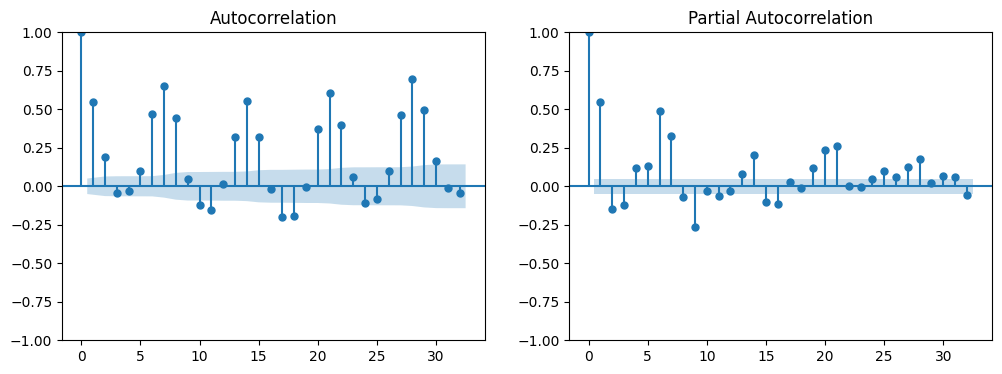

In [23]:
plot_acf_pacf(train_ts)

In [24]:
model1 = AutoARIMA(
    start_p = 1,
    start_q = 1,
    max_p = 5,
    max_q = 5,
    d = 1,
    max_P = 5,
    max_Q = 5,
    D = 1,
    seasonal=True,
    season_length = 7,
    ic = 'aicc',
    trace = True,
    approximation=True
)

model1.fit(y=ts.y, X=None)

Fitting models using approximations to speed things up

ARIMA(1,1,1)(1,1,1)[7]                   :3192.993246022455

ARIMA(0,1,0)(0,1,0)[7]                   :5195.3961639338395

ARIMA(1,1,0)(1,1,0)[7]                   :3985.479258627468

ARIMA(0,1,1)(0,1,1)[7]                   :3197.344466741187

ARIMA(1,1,1)(0,1,1)[7]                   :3201.6060667533643

ARIMA(1,1,1)(1,1,0)[7]                   :3870.109957039091

ARIMA(1,1,1)(2,1,1)[7]                   :3193.908495449698

ARIMA(1,1,1)(1,1,2)[7]                   :inf

ARIMA(1,1,1)(0,1,0)[7]                   :4379.956479948513

ARIMA(1,1,1)(0,1,2)[7]                   :3202.4154275675132

ARIMA(1,1,1)(2,1,0)[7]                   :3565.6009751282904

ARIMA(1,1,1)(2,1,2)[7]                   :inf

ARIMA(0,1,1)(1,1,1)[7]                   :inf

ARIMA(1,1,0)(1,1,1)[7]                   :inf

ARIMA(2,1,1)(1,1,1)[7]                   :3179.8755877041954

ARIMA(2,1,1)(0,1,1)[7]                   :3159.235512878396

ARIMA(2,1,1)(0,1,0)

AutoARIMA

In [169]:
best_sarima = ARIMA(train_ts.y, order=(4, 1, 2), seasonal_order=(0, 1, 4, 7))
best_sarima = best_sarima.fit()
best_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                 1513
Model:             ARIMA(4, 1, 2)x(0, 1, [1, 2, 3, 4], 7)   Log Likelihood              -12140.099
Date:                                    Thu, 06 Feb 2025   AIC                          24302.198
Time:                                            14:22:12   BIC                          24360.680
Sample:                                                 0   HQIC                         24323.981
                                                   - 1513                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5697      0.066     -8.574      0.000      -0.700      -0.439
ar.L2          0.4314      0.035     12.201      0.000       0.362       0.501
ar.L3          0.1879      0.035      5.397      0.000       0.120       0.256
ar.L4          0.0901      0.029      3.099      0.002       0.033       0.147
ma.L1         -0.1313      0.062     -2.122      0.034      -0.253      -0.010
ma.L2         -0.8064      0.056    -14.393      0.000      -0.916      -0.697
ma.S.L7       -0.9359      0.028    -33.401      0.000      -0.991      -0.881
ma.S.L14      -0.0977      0.040     -2.459      0.014      -0.175      -0.020
ma.S.L21       0.0956      0.042      2.256      0.024       0.013       0.179
ma.S.L28      -0.0621      0.028     -2.238      0.025      -0.116      -0.008
sigma2       5.89e+05   4.52e-08    1.3e+13      0.000    5.89e+05    5.89e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):             20419.20
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -1.61
Prob(H) (two-sided):                  0.89   Kurtosis:                        20.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.69e+28. Standard errors may be unstable.
"""

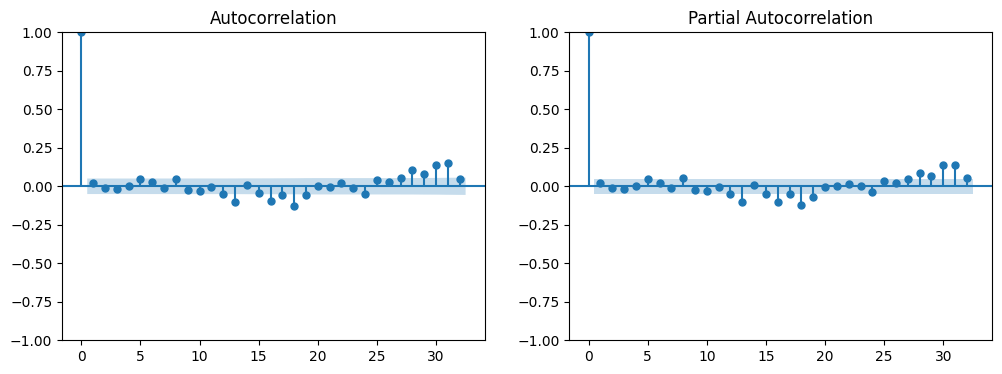

In [170]:
plot_acf_pacf(pd.DataFrame({'y':best_sarima.resid.dropna().values}))

In [171]:
acorr_ljungbox(best_sarima.resid, return_df=True)

,lb_stat,lb_pvalue
1,0.518,0.472
2,0.817,0.664
3,1.422,0.700
4,1.444,0.837
5,5.160,0.397
6,6.206,0.401
7,6.438,0.490
8,9.916,0.271
9,10.863,0.285
10,12.240,0.269


Считаем MAPE для полученной модели и делаем финальное предсказание.

In [172]:
mape1 = ((val_ts.y - best_sarima.forecast(VALIDATION_HORIZON)) / val_ts.y).values.mean()
print(f"MAPE FOR SARIMA = {mape1}")

MAPE FOR SARIMA = 0.01484683134793497


In [180]:
final_sarima = ARIMA(ts.y, order=(4, 1, 2), seasonal_order=(0, 1, 4, 7))
final_sarima = final_sarima.fit()
preds = final_sarima.forecast(VALIDATION_HORIZON).values
pd.Series(preds).to_csv('solution.csv', header=False, index=False)

# Добавляем экзогенные признаки

In [29]:
calendar = calendar.rename(columns={'date': 'ds'})

ts_merged = ts.merge(calendar, on='ds')
ts_merged.head(3)

,ds,y,holiday_1,holiday_2,exog_param
0,2011-01-29,6853,not,not,0
1,2011-01-30,7030,not,not,0
2,2011-01-31,5124,not,not,0


In [48]:
# Энкодим категориальные признаки

cat_features = ['holiday_1', 'holiday_2']
extra_cols = ['ds', 'y']

ohe = OneHotEncoder(drop='first')
enc_features = ohe.fit_transform(ts_merged[cat_features]).toarray().astype(int)
name_features = ohe.get_feature_names_out(cat_features)
enc_df = pd.DataFrame(enc_features, columns=name_features)
ts_merged_enc = pd.concat([ts_merged.drop(columns=cat_features), enc_df], axis=1)
ts_merged_enc.head(3)

,ds,y,exog_param,holiday_1_National,holiday_1_Religious,holiday_1_Sporting,holiday_1_not,holiday_2_Religious,holiday_2_not
0,2011-01-29,6853,0,0,0,0,1,0,1
1,2011-01-30,7030,0,0,0,0,1,0,1
2,2011-01-31,5124,0,0,0,0,1,0,1


Подберём оптимальные значения параметров для SARIMAX

In [49]:
model2 = AutoARIMA(
    start_p = 1,
    start_q = 1,
    max_p = 5,
    max_q = 5,
    d = 1,
    max_P = 5,
    max_Q = 5,
    D = 1,
    seasonal=True,
    season_length = 7,
    ic = 'aicc',
    trace = True,
    stepwise = True,
    approximation=True
)

model2.fit(y=ts_merged_enc['y'].values, X=ts_merged_enc.drop(columns=extra_cols).values.astype('float'))

Fitting models using approximations to speed things up

Regression with ARIMA(1,1,1)(1,1,1)[7] errors:29812.09831312442

Regression with ARIMA(0,1,0)(0,1,0)[7] errors:31405.56324890685

Regression with ARIMA(1,1,0)(1,1,0)[7] errors:30691.92005748006

Regression with ARIMA(0,1,1)(0,1,1)[7] errors:29803.25592927297

Regression with ARIMA(0,1,1)(0,1,0)[7] errors:30723.725699897484

Regression with ARIMA(0,1,1)(1,1,1)[7] errors:inf

Regression with ARIMA(0,1,1)(0,1,2)[7] errors:29791.742409473387

Regression with ARIMA(0,1,1)(1,1,2)[7] errors:inf

Regression with ARIMA(0,1,1)(0,1,3)[7] errors:29780.9364062306

Regression with ARIMA(0,1,1)(1,1,3)[7] errors:inf

Regression with ARIMA(0,1,1)(0,1,4)[7] errors:29782.197311796976

Regression with ARIMA(0,1,1)(1,1,4)[7] errors:inf

Regression with ARIMA(0,1,0)(0,1,3)[7] errors:30428.458923662653

Regression with ARIMA(1,1,1)(0,1,3)[7] errors:29714.763967547948

Regression with ARIMA(1,1,1)(0,1,2)[7] errors:29714.097637508195

Regression with ARIM

AutoARIMA

Обучаем оптимальную SARIMAX

In [50]:
best_sarimax1 = ARIMA(
    endog=ts_merged_enc.y.values,
    exog=ts_merged_enc.drop(columns=extra_cols).values.astype('float'),
    order=(2,1,1),
    seasonal_order=(0,1,2,7)
)

best_sarimax1 = best_sarimax1.fit()
best_sarimax1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 1879
Model:             ARIMA(2, 1, 1)x(0, 1, [1, 2], 7)   Log Likelihood              -14865.678
Date:                              Fri, 07 Feb 2025   AIC                          29757.356
Time:                                      07:28:13   BIC                          29829.301
Sample:                                           0   HQIC                         29783.862
                                             - 1879                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           838.8711     39.026     21.495      0.000     762.381     915.361
x2           489.3119    160.581      3.047      0.002     174.579     804.045
x3           516.3954    183.983      2.807      0.005     155.795     876.996
x4           224.9318    191.661      1.174      0.241    -150.716     600.580
x5           471.8515    149.695      3.152      0.002     178.454     765.249
x6          1039.9734   1187.804      0.876      0.381   -1288.079    3368.026
x7           799.6085    623.445      1.283      0.200    -422.321    2021.538
ar.L1          0.2545      0.016     15.960      0.000       0.223       0.286
ar.L2          0.0572      0.020      2.830      0.005       0.018       0.097
ma.L1         -0.9460      0.010    -90.409      0.000      -0.967      -0.926
ma.S.L7       -0.8427      0.024    -35.548      0.000      -0.889      -0.796
ma.S.L14      -0.1573      0.018     -8.965      0.000      -0.192      -0.123
sigma2      4.564e+05      0.041    1.1e+07      0.000    4.56e+05    4.56e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             73342.14
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                            -1.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.02e+24. Standard errors may be unstable.
"""

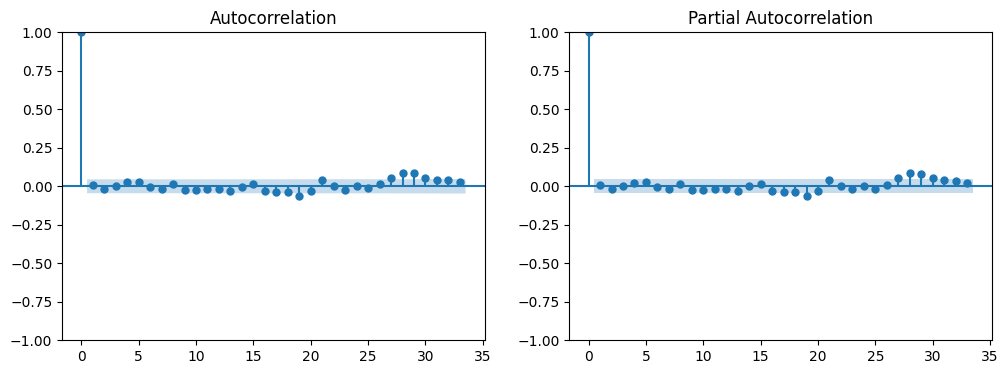

In [52]:
plot_acf_pacf(best_sarimax1.resid)

In [53]:
acorr_ljungbox(best_sarimax1.resid, return_df=True)

,lb_stat,lb_pvalue
1,0.091,0.763
2,0.695,0.706
3,0.706,0.872
4,1.868,0.760
5,3.136,0.679
6,3.148,0.790
7,3.699,0.814
8,4.217,0.837
9,5.092,0.826
10,6.178,0.800


Делаем финальный предикт

In [70]:
first_date = pd.to_datetime('2016-03-22')
second_date = pd.to_datetime('2016-05-22')

test_df = calendar.set_index('ds').loc[first_date:second_date]
test_enc = ohe.transform(test_df[cat_features]).toarray()
X_test = np.concatenate([test_df.exog_param.values.reshape(-1, 1), test_enc],axis=1)

In [71]:
forecast_test_sarimax = best_sarimax1.forecast(VALIDATION_HORIZON, exog=X_test)
preds = forecast_test_sarimax
pd.Series(preds).to_csv('solution.csv', header=False, index=False)